# VAE on MINIST dataset

In this homework, we play with VAE model on the MNIST dataset. The materials are from https://github.com/pytorch/examples/blob/master/vae/main.py.

- We use python 3.0
- With more explanations

In [34]:
# load the modules

## load pytorch module
import torch

## load torch data manager: Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader

## load neural network module
from torch import nn
from torch.nn import functional as F

## load optimizer
from torch import optim

## load modules for MNIST dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image

## load other python modules
### plt to view the image
import matplotlib.pyplot as plt

### load MNIST dataset

In [18]:
## download MNIST trainign dataset 
train_dataset: Dataset = datasets.MNIST("./data", train = True, download = True,
                                       transform = transforms.ToTensor())
## class Dataset provides:
## - function "__len__": to get the size of the dataset
## - function "__getitem__": to get the data point by the index

## show the data size
print(train_dataset)
## show one data point
## each data point has two element: one is the image, one is which number it is.

## print the tensor size: (1, 28, 28): 
## the first dim: 1 is the number of channel (only one) here
## the second and third dim: the width and height for this channel.
print(train_dataset[0][0].shape)

## print the number
print(train_dataset[0][1])

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([1, 28, 28])
5


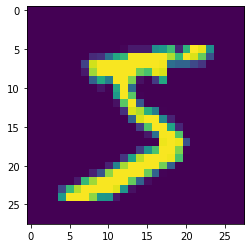

In [24]:
## let's view this image
plt.imshow(train_dataset[0][0][0])

### Use Dataloader to wrap up the dataset

During the learning process, we will use stochasitic optmization, which means we will shuffle the sample, and put a small part of the dataset into the optimizer. You can do this by yourself, but pytorch actually provides the data manager named Dataloader to simplify this process, and it is usually used together with the Dataset class.

In [23]:
## you can choose whatever batch_size you want.
## shuffle = True, means every epoch, we will shuffle the samplers 
## by the sampling algorithm you or the default one.
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
## we don't need to shuffle the samples during test.
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

## VAE 

In [48]:
## All the neural networks are implemented as the class of nn.Module in pytorch.
## It need to provide the function named "forward" to declare how it transform a tensor.

class VAE(nn.Module):
    ## __init__ is the basic syntax in python. when you want to describe a class, you need this 
    ## to tell python how to initialize this class.
    def __init__(self):
        ## all the modules need this firstly to initialize itself.
        super().__init__()
        ## then we define several neural network structure
        
        ## pytorch provides lots of neural network structures under the nn module. you can check it yourself.
        ## here we just use the simpliest linear transformation
        
        ## [QUESTION]: why we use the numebr 784 here?
        
        ## this linear transformation is a typical one-layer fully connected neural network
        ## with input dim 784, and output dim 400.
        
        ## [QUESTION]: how many parameters we use for the five fully connected neural networks? 
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
        
    ## now let's move forward to implement the VAE, a typical VAE involves
    ## - an encoder: define q(z|x), i.e., the mean and variance of the Gaussian distribution
    ## - a decoder: defile p(x|z)
    ## - the implementation of reparameterization
    
    def encode(self, x):
        ## generate the mean and log of the variance of q(z|x)
        ## we assume that z_i and z_j are independent for any z_i, z_j \in z and i != j
        h1 = F.relu(self.fc1(x))
        
        ## [QUESTION]: what's dimention or size of the two outputs? 
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):    
        std = torch.exp(0.5*logvar)
        
        ## we sample the eps from a standard normal distribution, 
        ## whose shape or dimention is the same as std
        
        ## [QUESTION]: do you know how many samples we use to approxmate the derivates of ELBO
        ## base on the expression below? 
        eps = torch.randn_like(std)
        
        ## [QUESTION]: why we need to do the reparameterization?
        return mu + eps*std
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        ## [QUESTION]: do you know what's the p(x/z) is used here?
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        ## x is a typical mini-batch samples.
        ## view function is used to re-define the dimension of x in order to output the  
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar  
    
model = VAE()
print(model)

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)


## Define the loss function

In [49]:
## Now let's define the loss function of VAE. 
## There are two parts:
## - the loss of reconstructio, i.e., - p(x|z)
## - the KL divergence towards the prior, i.e., KL(q(z|x) ||  p(z))

## binary cross entropy loss
reconst_loss = nn.BCELoss(reduction = 'sum')

def loss_function(recon_x, x, mu, logvar):
    rcloss = reconst_loss(recon_x, x.view(-1, 784))
    ## analytic formulation of KL divergence of Gaussian distribution. 
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return rcloss + kld

## Select the optimizer

In [60]:
## lots of the optimizers you can select in torch.
## nowadays, people use Adam a lot.
## An interesting thing: the first author of Adam is the same first author of VAE.
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

## Let's start to train VAE!

In [61]:
## Epoch: once we run through all the samples in the training dataset, we finish one epoch. 
def train(epoch):
    ## [IMPORTANT]: in pytorch, model will update the parameters when it's in training state.
    model.train()
    train_loss = 0
    ## we ignore the labels of MNIST, and only use the images.
    for batch_id, (x, _) in enumerate(train_loader):
        ## [IMPORTANT]: each differentiable tensor in pytorch will recognize the previous gradient.
        ## so we have to set them as zeros before we compute next time.
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(x)
        loss = loss_function(recon_batch, x, mu, logvar)
        
        ## we do the back propagation on the tensor generated by the loss function.
        loss.backward()
        
        ## then update the parameters by the optmizer.
        optimizer.step()
        
        ## let's remember the loss
        train_loss += loss.item()
        
        ## print the loss
        if batch_id % 500 == 0:
            print(f"Train Epoch {epoch} [{batch_id}]: loss {loss.item() / len(x)}")
    print(f"Epoch: {epoch} average loss: {train_loss / len(train_loader.dataset)}")

        

In [ ]:
for epoch in range(10):
    train(epoch)


Train Epoch 0 [0]: loss 111.1076889038086
